In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score, confusion_matrix
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import KMeans
import tensorflow.keras as keras
import csv

In [2]:
X_scr_pin = []
Y_scr_pin = []

X_scr_ban = []
Y_scr_ban = []

X_pin_ban = []
Y_pin_ban = []

with open('./scorpions_pinginus.csv', newline='') as csfile:
    spamreader = csv.reader(csfile, delimiter=' ', quotechar='|')
    for row in spamreader:
        X_scr_pin.append(row[0])
        Y_scr_pin.append(int(row[1]))

with open('./scorpions_bananka.csv', newline='') as csfile:
    spamreader = csv.reader(csfile, delimiter=' ', quotechar='|')
    for row in spamreader:
        X_scr_ban.append(row[0])
        Y_scr_ban.append(int(row[1]))

with open('./pinginus_bananka.csv', newline='') as csfile:
    spamreader = csv.reader(csfile, delimiter=' ', quotechar='|')
    for row in spamreader:
        X_pin_ban.append(row[0])
        Y_pin_ban.append(int(row[1]))

In [3]:
X_train_scr_pin, X_test_scr_pin, Y_train_scr_pin, Y_test_scr_pin = train_test_split(X_scr_pin, Y_scr_pin, test_size=0.2)

X_train_scr_ban, X_test_scr_ban, Y_train_scr_ban, Y_test_scr_ban = train_test_split(X_scr_ban, Y_scr_ban, test_size=0.2)

X_train_pin_ban, X_test_pin_ban, Y_train_pin_ban, Y_test_pin_ban = train_test_split(X_pin_ban, Y_pin_ban, test_size=0.2)

In [4]:
def compute_data(X, n=8):

    kaze = cv2.KAZE_create()
    m = len(X)
    X_res = np.zeros((m,n))
    i = 0
    for x in X:
        img = cv2.imread(x, 0)
        img = cv2.resize(img, (128, 128))
        kp, des = kaze.detectAndCompute(img, None)

        pt = [i.pt for i in kp]
        pt_arr = np.array(pt)
        if pt_arr.shape[0] < n:
            if len(pt) != 0:
                for j in range(pt_arr.shape[0]):
                    X_res[i,j] = 1 / pt_arr.shape[0]
        else:
            kmeans = KMeans(n_clusters=n, random_state=0).fit(pt_arr)
            list_masks = [ kmeans.labels_ == i for i in range(n)]

            j = 0
            for mask in list_masks:
                pt_mask = np.round(pt_arr[mask,:], 0).astype(np.int)
                hist = np.sum(img[pt_mask[:,0], pt_mask[:,1]]) / np.sum(mask)
                X_res[i,j] = hist
                j += 1
        i += 1

    return X_res

In [5]:
train_scr_pin = compute_data(X_train_scr_pin)
train_scr_ban = compute_data(X_train_scr_ban)
train_pin_ban = compute_data(X_train_pin_ban)

y_train_scr_pin = np.zeros((train_scr_pin.shape[0], 2))
y_train_scr_ban = np.zeros((train_scr_ban.shape[0], 2))
y_train_pin_ban = np.zeros((train_pin_ban.shape[0], 2))

for i in range(train_scr_pin.shape[0]):
    y_train_scr_pin[i, Y_train_scr_pin[i]] = 1

for i in range(train_scr_ban.shape[0]):
    y_train_scr_ban[i, Y_train_scr_ban[i]] = 1

for i in range(train_pin_ban.shape[0]):
    y_train_pin_ban[i, Y_train_pin_ban[i]] = 1

test_scr_pin = compute_data(X_test_scr_pin)
test_scr_ban = compute_data(X_test_scr_ban)
test_pin_ban = compute_data(X_test_pin_ban)

y_test_scr_pin = np.array(Y_test_scr_pin)
y_test_scr_ban = np.array(Y_test_scr_ban)
y_test_pin_ban = np.array(Y_test_pin_ban)

# LSTM

In [6]:
def model(n=8):
    key_points = keras.layers.Input(shape=(1,n), dtype='float32')
    X = keras.layers.BatchNormalization()(key_points)
    X = keras.layers.LSTM(512, return_sequences=True)(X)
    X = keras.layers.Dropout(rate=0.5)(X)
    X = keras.layers.LSTM(512, return_sequences=True)(X)
    X = keras.layers.Dropout(rate=0.5)(X)
    X = keras.layers.LSTM(512, return_sequences=False)(X)
    X = keras.layers.Dropout(rate=0.5)(X)
    X = keras.layers.Dense(units=2)(X)
    X = keras.layers.Activation(activation='softmax')(X)

    model = keras.Model(inputs=key_points, outputs=X)

    return model

In [7]:
example = model(n=8)
example.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1, 8)]            0         
_________________________________________________________________
batch_normalization (BatchNo (None, 1, 8)              32        
_________________________________________________________________
lstm (LSTM)                  (None, 1, 512)            1067008   
_________________________________________________________________
dropout (Dropout)            (None, 1, 512)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 1, 512)            2099200   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 512)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 512)              

In [8]:
model_scr_pin = model()
model_scr_ban = model()
model_pin_ban = model()

In [9]:
model_scr_pin.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_scr_ban.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_pin_ban.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [10]:
X_train_scr_pin_arr = train_scr_pin[:, np.newaxis, :]
X_train_scr_ban_arr = train_scr_ban[:, np.newaxis, :]
X_train_pin_ban_arr = train_pin_ban[:, np.newaxis, :]


X_test_scr_pin_arr = test_scr_pin[:,np.newaxis, :]
X_test_scr_ban_arr = test_scr_ban[:,np.newaxis, :]
X_test_pin_ban_arr = test_pin_ban[:,np.newaxis, :]

In [43]:
model_scr_pin.fit(X_train_scr_pin_arr, y_train_scr_pin, epochs=52, batch_size=32, shuffle=True)

Epoch 1/52
22/22 [==============================] - 1s 26ms/step - loss: 0.6337 - accuracy: 0.6032
Epoch 2/52
22/22 [==============================] - 1s 27ms/step - loss: 0.6212 - accuracy: 0.6372
Epoch 3/52
22/22 [==============================] - 1s 26ms/step - loss: 0.6275 - accuracy: 0.6032
Epoch 4/52
22/22 [==============================] - 1s 27ms/step - loss: 0.6049 - accuracy: 0.6475
Epoch 5/52
22/22 [==============================] - 1s 30ms/step - loss: 0.6247 - accuracy: 0.6283
Epoch 6/52
22/22 [==============================] - 1s 30ms/step - loss: 0.6164 - accuracy: 0.6327
Epoch 7/52
22/22 [==============================] - 1s 30ms/step - loss: 0.6215 - accuracy: 0.6445
Epoch 8/52
22/22 [==============================] - 1s 26ms/step - loss: 0.6070 - accuracy: 0.6372
Epoch 9/52
22/22 [==============================] - 1s 26ms/step - loss: 0.6103 - accuracy: 0.6445
Epoch 10/52
22/22 [==============================] - 1s 26ms/step - loss: 0.5860 - accuracy: 0.6578
Epoch 11/

In [12]:
model_scr_ban.fit(X_train_scr_ban_arr, y_train_scr_ban, epochs=52, batch_size=32, shuffle=True)

Epoch 1/52
21/21 [==============================] - 1s 28ms/step - loss: 0.6933 - accuracy: 0.4841
Epoch 2/52
21/21 [==============================] - 1s 28ms/step - loss: 0.6920 - accuracy: 0.4856
Epoch 3/52
21/21 [==============================] - 1s 27ms/step - loss: 0.6823 - accuracy: 0.5220
Epoch 4/52
21/21 [==============================] - 1s 27ms/step - loss: 0.6687 - accuracy: 0.5387
Epoch 5/52
21/21 [==============================] - 1s 27ms/step - loss: 0.6524 - accuracy: 0.5948
Epoch 6/52
21/21 [==============================] - 1s 27ms/step - loss: 0.6521 - accuracy: 0.6115
Epoch 7/52
21/21 [==============================] - 1s 27ms/step - loss: 0.6470 - accuracy: 0.6024
Epoch 8/52
21/21 [==============================] - 1s 25ms/step - loss: 0.6431 - accuracy: 0.5994
Epoch 9/52
21/21 [==============================] - 1s 25ms/step - loss: 0.6450 - accuracy: 0.6146
Epoch 10/52
21/21 [==============================] - 1s 25ms/step - loss: 0.6543 - accuracy: 0.5979
Epoch 11/

In [13]:
model_pin_ban.fit(X_train_pin_ban_arr, y_train_pin_ban, epochs=52, batch_size=32, shuffle=True)

Epoch 1/52
22/22 [==============================] - 1s 25ms/step - loss: 0.6928 - accuracy: 0.4941
Epoch 2/52
22/22 [==============================] - 1s 25ms/step - loss: 0.6905 - accuracy: 0.5162
Epoch 3/52
22/22 [==============================] - 1s 26ms/step - loss: 0.6823 - accuracy: 0.5590
Epoch 4/52
22/22 [==============================] - 1s 25ms/step - loss: 0.6610 - accuracy: 0.6180
Epoch 5/52
22/22 [==============================] - 1s 26ms/step - loss: 0.6549 - accuracy: 0.6180
Epoch 6/52
22/22 [==============================] - 1s 26ms/step - loss: 0.6415 - accuracy: 0.6726
Epoch 7/52
22/22 [==============================] - 1s 25ms/step - loss: 0.6311 - accuracy: 0.6563
Epoch 8/52
22/22 [==============================] - 1s 26ms/step - loss: 0.6293 - accuracy: 0.6534
Epoch 9/52
22/22 [==============================] - 1s 25ms/step - loss: 0.6230 - accuracy: 0.6593
Epoch 10/52
22/22 [==============================] - 1s 26ms/step - loss: 0.6414 - accuracy: 0.6519
Epoch 11/

In [44]:
y_pred_scr_pin = model_scr_pin.predict(X_test_scr_pin_arr)
y_pred_scr_pin_target = np.argmax(y_pred_scr_pin, axis=1)

y_pred_scr_ban = model_scr_ban.predict(X_test_scr_ban_arr)
y_pred_scr_ban_target = np.argmax(y_pred_scr_ban, axis=1)

y_pred_pin_ban = model_pin_ban.predict(X_test_pin_ban_arr)
y_pred_pin_ban_target = np.argmax(y_pred_pin_ban, axis=1)

In [45]:
accuracy_scr_pin = recall_score(y_test_scr_pin, y_pred_scr_pin_target)
accuracy_scr_ban = recall_score(y_test_scr_ban, y_pred_scr_ban_target)
accuracy_pin_ban = recall_score(y_test_pin_ban, y_pred_pin_ban_target)

recall_scr_pin = recall_score(y_test_scr_pin, y_pred_scr_pin_target)
recall_scr_ban = recall_score(y_test_scr_ban, y_pred_scr_ban_target)
recall_pin_ban = recall_score(y_test_pin_ban, y_pred_pin_ban_target)

precision_scr_pin = precision_score(y_test_scr_pin, y_pred_scr_pin_target)
precision_scr_ban = precision_score(y_test_scr_ban, y_pred_scr_ban_target)
precision_pin_ban = precision_score(y_test_pin_ban, y_pred_pin_ban_target)

f1_scr_pin = f1_score(y_test_scr_pin, y_pred_scr_pin_target)
f1_scr_ban = f1_score(y_test_scr_ban, y_pred_scr_ban_target)
f1_pin_ban = f1_score(y_test_pin_ban, y_pred_pin_ban_target)

confusion_matrix_scr_pin = pd.DataFrame(confusion_matrix(y_test_scr_pin, y_pred_scr_pin_target))
confusion_matrix_scr_ban = pd.DataFrame(confusion_matrix(y_test_scr_ban, y_pred_scr_ban_target))
confusion_matrix_pin_ban = pd.DataFrame(confusion_matrix(y_test_pin_ban, y_pred_pin_ban_target))

Scorpions Pinginus
accuracy: 0.5238095238095238
recall: 0.5238095238095238
precission: 0.5641025641025641
f1: 0.5432098765432098


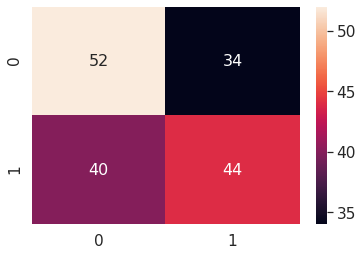

In [46]:
print('Scorpions Pinginus')
print(f'accuracy: {accuracy_scr_pin}')
print(f'recall: {recall_scr_pin}')
print(f'precission: {precision_scr_pin}')
print(f'f1: {f1_scr_pin}')

sn.set(font_scale=1.4)
sn.heatmap(confusion_matrix_scr_pin, annot=True, annot_kws={'size': 16})


Scorpions Bananka
accuracy: 0.5232558139534884
recall: 0.5232558139534884
precission: 0.6428571428571429
f1: 0.5769230769230771


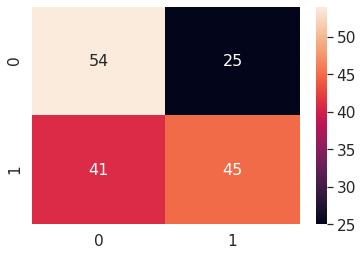

In [17]:
print('Scorpions Bananka')
print(f'accuracy: {accuracy_scr_ban}')
print(f'recall: {recall_scr_ban}')
print(f'precission: {precision_scr_ban}')
print(f'f1: {f1_scr_ban}')

sn.set(font_scale=1.4)
sn.heatmap(confusion_matrix_scr_ban, annot=True, annot_kws={'size': 16})

Pinginus Bananka
accuracy: 0.7209302325581395
recall: 0.7209302325581395
precission: 0.7045454545454546
f1: 0.7126436781609196


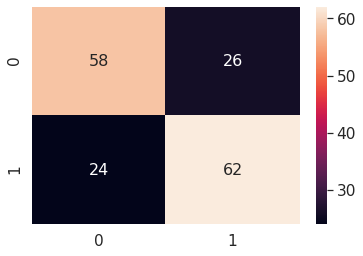

In [18]:
print('Pinginus Bananka')
print(f'accuracy: {accuracy_pin_ban}')
print(f'recall: {recall_pin_ban}')
print(f'precission: {precision_pin_ban}')
print(f'f1: {f1_pin_ban}')

sn.set(font_scale=1.4)
sn.heatmap(confusion_matrix_pin_ban, annot=True, annot_kws={'size': 16})

In [19]:
def compute_hist(frame, n=8):
    kaze = cv2.KAZE_create()
    m = 1
    X_res = np.zeros((m,n))

    img = cv2.resize(cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY), (128, 128))
    kp, des = kaze.detectAndCompute(img, None)

    pt = [i.pt for i in kp]
    pt_arr = np.array(pt)

    if pt_arr.shape[0] < n:
        if len(pt) != 0:
            for j in range(pt_arr.shape[0]):
                X_res[0,j] = 1 / pt_arr.shape[0]
    else:
        kmeans = KMeans(n_clusters=n, random_state=0).fit(pt_arr)
        list_masks = [ kmeans.labels_ == i for i in range(n)]

        j = 0
        for mask in list_masks:
            pt_mask = np.round(pt_arr[mask,:], 0).astype(np.int)
            hist = np.sum(img[pt_mask[:,0], pt_mask[:,1]]) / np.sum(mask)
            X_res[0,j] = hist
            j += 1

    return X_res

In [20]:
cap = cv2.VideoCapture('test.mp4')

if (cap.isOpened() == False):
    print("Unable to read camera feed")

frame_width = int(cap.get(4))
frame_height = int(cap.get(3))

out = cv2.VideoWriter('scor_pin.avi',cv2.VideoWriter_fourcc('M','J','P','G'), 10, (frame_width,frame_height))

while(True):
    ret, frame = cap.read()

    if ret == True:
        frame = cv2.rotate(frame, cv2.ROTATE_90_CLOCKWISE)
        X = compute_hist(frame)[np.newaxis, :, :]
        class_object = np.argmax(model_scr_pin.predict(X))
        position = (25, 350)
        cv2.putText(frame, 'Class ' + str(class_object), position, cv2.FONT_HERSHEY_SIMPLEX, 2, (209, 80, 0, 255), 3)
        out.write(frame)

    else:
        break

cap.release()
out.release()

cv2.destroyAllWindows()

In [21]:
cap = cv2.VideoCapture('test.mp4')

if (cap.isOpened() == False):
    print("Unable to read camera feed")

frame_width = int(cap.get(4))
frame_height = int(cap.get(3))

out = cv2.VideoWriter('scor_ban.avi',cv2.VideoWriter_fourcc('M','J','P','G'), 10, (frame_width,frame_height))

while(True):
    ret, frame = cap.read()

    if ret == True:
        frame = cv2.rotate(frame, cv2.ROTATE_90_CLOCKWISE)
        X = compute_hist(frame)[np.newaxis, :, :]
        class_object = np.argmax(model_scr_ban.predict(X))
        position = (25, 350)
        cv2.putText(frame, 'Class ' + str(class_object), position, cv2.FONT_HERSHEY_SIMPLEX, 2, (209, 80, 0, 255), 3)
        out.write(frame)

    else:
        break

cap.release()
out.release()

cv2.destroyAllWindows()

In [22]:
model_scr_pin.save('./model_scr_pin')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: ./model_scr_pin/assets


In [23]:
model_scr_ban.save('./model_scr_ban')

INFO:tensorflow:Assets written to: ./model_scr_ban/assets


In [24]:
model_pin_ban.save('./model_pin_ban')

INFO:tensorflow:Assets written to: ./model_pin_ban/assets


# SVM

In [25]:
target_train_scr_pin = np.array(Y_train_scr_pin)
target_train_scr_ban = np.array(Y_train_scr_ban)
target_train_pin_ban = np.array(Y_train_pin_ban)

In [26]:
svc_scr_pin = SVC(kernel='sigmoid', coef0=10**-6, C=1, gamma='auto')
svc_scr_ban = SVC(kernel='sigmoid', coef0=10**-6, C=1, gamma='auto')
svc_pin_ban = SVC(kernel='sigmoid', coef0=10**-6, C=1, gamma='auto')

svc_scr_pin.fit(train_scr_pin, target_train_scr_pin)
svc_scr_ban.fit(train_scr_ban, target_train_scr_ban)
svc_pin_ban.fit(train_pin_ban, target_train_pin_ban)

SVC(C=1, coef0=1e-06, gamma='auto', kernel='sigmoid')

In [27]:
y_pred_scr_pin = svc_scr_pin.predict(test_scr_pin)

y_pred_scr_ban = svc_scr_ban.predict(test_scr_ban)

y_pred_pin_ban = svc_pin_ban.predict(test_pin_ban)

In [28]:
accuracy_scr_pin = recall_score(y_test_scr_pin, y_pred_scr_pin)
accuracy_scr_ban = recall_score(y_test_scr_ban, y_pred_scr_ban)
accuracy_pin_ban = recall_score(y_test_pin_ban, y_pred_pin_ban)

recall_scr_pin = recall_score(y_test_scr_pin, y_pred_scr_pin)
recall_scr_ban = recall_score(y_test_scr_ban, y_pred_scr_ban)
recall_pin_ban = recall_score(y_test_pin_ban, y_pred_pin_ban)

precision_scr_pin = precision_score(y_test_scr_pin, y_pred_scr_pin)
precision_scr_ban = precision_score(y_test_scr_ban, y_pred_scr_ban)
precision_pin_ban = precision_score(y_test_pin_ban, y_pred_pin_ban)

f1_scr_pin = f1_score(y_test_scr_pin, y_pred_scr_pin)
f1_scr_ban = f1_score(y_test_scr_ban, y_pred_scr_ban)
f1_pin_ban = f1_score(y_test_pin_ban, y_pred_pin_ban)

confusion_matrix_scr_pin = pd.DataFrame(confusion_matrix(y_test_scr_pin, y_pred_scr_pin))
confusion_matrix_scr_ban = pd.DataFrame(confusion_matrix(y_test_scr_ban, y_pred_scr_ban))
confusion_matrix_pin_ban = pd.DataFrame(confusion_matrix(y_test_pin_ban, y_pred_pin_ban))

/home/petro/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Scorpions Pinginus
accuracy: 0.05952380952380952
recall: 0.05952380952380952
precission: 0.625
f1: 0.10869565217391304


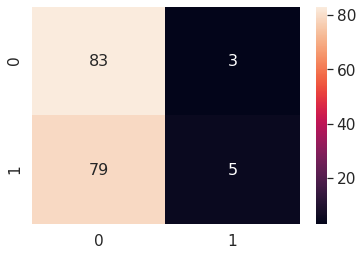

In [29]:
print('Scorpions Pinginus')
print(f'accuracy: {accuracy_scr_pin}')
print(f'recall: {recall_scr_pin}')
print(f'precission: {precision_scr_pin}')
print(f'f1: {f1_scr_pin}')

sn.set(font_scale=1.4)
sn.heatmap(confusion_matrix_scr_pin, annot=True, annot_kws={'size': 16})


Scorpions Bananka
accuracy: 0.0
recall: 0.0
precission: 0.0
f1: 0.0


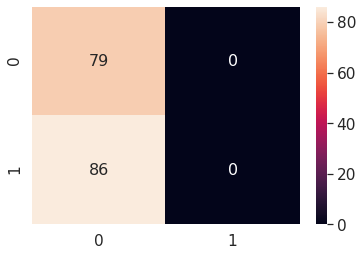

In [30]:
print('Scorpions Bananka')
print(f'accuracy: {accuracy_scr_ban}')
print(f'recall: {recall_scr_ban}')
print(f'precission: {precision_scr_ban}')
print(f'f1: {f1_scr_ban}')

sn.set(font_scale=1.4)
sn.heatmap(confusion_matrix_scr_ban, annot=True, annot_kws={'size': 16})

Pinginus Bananka
accuracy: 0.9651162790697675
recall: 0.9651162790697675
precission: 0.49700598802395207
f1: 0.6561264822134388


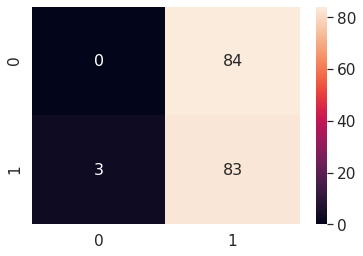

In [31]:
print('Pinginus Bananka')
print(f'accuracy: {accuracy_pin_ban}')
print(f'recall: {recall_pin_ban}')
print(f'precission: {precision_pin_ban}')
print(f'f1: {f1_pin_ban}')

sn.set(font_scale=1.4)
sn.heatmap(confusion_matrix_pin_ban, annot=True, annot_kws={'size': 16})

In [32]:
cap = cv2.VideoCapture('test.mp4')

if (cap.isOpened() == False):
    print("Unable to read camera feed")

frame_width = int(cap.get(4))
frame_height = int(cap.get(3))

out = cv2.VideoWriter('scor_pin_svm.avi',cv2.VideoWriter_fourcc('M','J','P','G'), 10, (frame_width,frame_height))

while(True):
    ret, frame = cap.read()

    if ret == True:
        frame = cv2.rotate(frame, cv2.ROTATE_90_CLOCKWISE)
        X = compute_hist(frame)
        class_object = svc_scr_pin.predict(X)
        position = (25, 350)
        cv2.putText(frame, 'Class ' + str(class_object), position, cv2.FONT_HERSHEY_SIMPLEX, 2, (209, 80, 0, 255), 3)
        out.write(frame)

    else:
        break

cap.release()
out.release()

cv2.destroyAllWindows()

In [33]:
cap = cv2.VideoCapture('test.mp4')

if (cap.isOpened() == False):
    print("Unable to read camera feed")

frame_width = int(cap.get(4))
frame_height = int(cap.get(3))

out = cv2.VideoWriter('scor_ban_svm.avi',cv2.VideoWriter_fourcc('M','J','P','G'), 10, (frame_width,frame_height))

while(True):
    ret, frame = cap.read()

    if ret == True:
        frame = cv2.rotate(frame, cv2.ROTATE_90_CLOCKWISE)
        X = compute_hist(frame)
        class_object = svc_scr_ban.predict(X)
        position = (25, 350)
        cv2.putText(frame, 'Class ' + str(class_object), position, cv2.FONT_HERSHEY_SIMPLEX, 2, (209, 80, 0, 255), 3)
        out.write(frame)

    else:
        break

cap.release()
out.release()

cv2.destroyAllWindows()

# DecissionTree

In [34]:
target_train_scr_pin = np.array(Y_train_scr_pin)
target_train_scr_ban = np.array(Y_train_scr_ban)
target_train_pin_ban = np.array(Y_train_pin_ban)

In [35]:
tree_scr_pin = DecisionTreeClassifier()
tree_scr_ban = DecisionTreeClassifier()
tree_pin_ban = DecisionTreeClassifier()

tree_scr_pin.fit(train_scr_pin, target_train_scr_pin)
tree_scr_ban.fit(train_scr_ban, target_train_scr_ban)
tree_pin_ban.fit(train_pin_ban, target_train_pin_ban)

DecisionTreeClassifier()

In [36]:
y_pred_scr_pin = tree_scr_pin.predict(test_scr_pin)

y_pred_scr_ban = tree_scr_ban.predict(test_scr_ban)

y_pred_pin_ban = tree_pin_ban.predict(test_pin_ban)

In [37]:
accuracy_scr_pin = recall_score(y_test_scr_pin, y_pred_scr_pin)
accuracy_scr_ban = recall_score(y_test_scr_ban, y_pred_scr_ban)
accuracy_pin_ban = recall_score(y_test_pin_ban, y_pred_pin_ban)

recall_scr_pin = recall_score(y_test_scr_pin, y_pred_scr_pin)
recall_scr_ban = recall_score(y_test_scr_ban, y_pred_scr_ban)
recall_pin_ban = recall_score(y_test_pin_ban, y_pred_pin_ban)

precision_scr_pin = precision_score(y_test_scr_pin, y_pred_scr_pin)
precision_scr_ban = precision_score(y_test_scr_ban, y_pred_scr_ban)
precision_pin_ban = precision_score(y_test_pin_ban, y_pred_pin_ban)

f1_scr_pin = f1_score(y_test_scr_pin, y_pred_scr_pin)
f1_scr_ban = f1_score(y_test_scr_ban, y_pred_scr_ban)
f1_pin_ban = f1_score(y_test_pin_ban, y_pred_pin_ban)

confusion_matrix_scr_pin = pd.DataFrame(confusion_matrix(y_test_scr_pin, y_pred_scr_pin))
confusion_matrix_scr_ban = pd.DataFrame(confusion_matrix(y_test_scr_ban, y_pred_scr_ban))
confusion_matrix_pin_ban = pd.DataFrame(confusion_matrix(y_test_pin_ban, y_pred_pin_ban))

Scorpions Pinginus
accuracy: 0.5476190476190477
recall: 0.5476190476190477
precission: 0.5227272727272727
f1: 0.5348837209302325


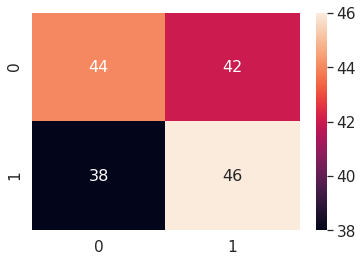

In [38]:
print('Scorpions Pinginus')
print(f'accuracy: {accuracy_scr_pin}')
print(f'recall: {recall_scr_pin}')
print(f'precission: {precision_scr_pin}')
print(f'f1: {f1_scr_pin}')

sn.set(font_scale=1.4)
sn.heatmap(confusion_matrix_scr_pin, annot=True, annot_kws={'size': 16})


Scorpions Bananka
accuracy: 0.5465116279069767
recall: 0.5465116279069767
precission: 0.6103896103896104
f1: 0.5766871165644172


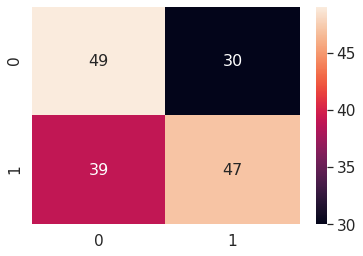

In [39]:
print('Scorpions Bananka')
print(f'accuracy: {accuracy_scr_ban}')
print(f'recall: {recall_scr_ban}')
print(f'precission: {precision_scr_ban}')
print(f'f1: {f1_scr_ban}')

sn.set(font_scale=1.4)
sn.heatmap(confusion_matrix_scr_ban, annot=True, annot_kws={'size': 16})

Pinginus Bananka
accuracy: 0.6046511627906976
recall: 0.6046511627906976
precission: 0.6265060240963856
f1: 0.6153846153846154


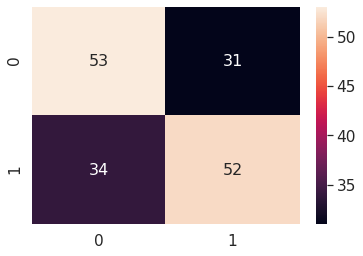

In [40]:
print('Pinginus Bananka')
print(f'accuracy: {accuracy_pin_ban}')
print(f'recall: {recall_pin_ban}')
print(f'precission: {precision_pin_ban}')
print(f'f1: {f1_pin_ban}')

sn.set(font_scale=1.4)
sn.heatmap(confusion_matrix_pin_ban, annot=True, annot_kws={'size': 16})

In [41]:
cap = cv2.VideoCapture('test.mp4')

if (cap.isOpened() == False):
    print("Unable to read camera feed")

frame_width = int(cap.get(4))
frame_height = int(cap.get(3))

out = cv2.VideoWriter('scor_pin_svm.avi',cv2.VideoWriter_fourcc('M','J','P','G'), 10, (frame_width,frame_height))

while(True):
    ret, frame = cap.read()

    if ret == True:
        frame = cv2.rotate(frame, cv2.ROTATE_90_CLOCKWISE)
        X = compute_hist(frame)
        class_object = tree_scr_pin.predict(X)
        position = (25, 350)
        cv2.putText(frame, 'Class ' + str(class_object), position, cv2.FONT_HERSHEY_SIMPLEX, 2, (209, 80, 0, 255), 3)
        out.write(frame)

    else:
        break

cap.release()
out.release()

cv2.destroyAllWindows()

In [42]:
cap = cv2.VideoCapture('test.mp4')

if (cap.isOpened() == False):
    print("Unable to read camera feed")

frame_width = int(cap.get(4))
frame_height = int(cap.get(3))

out = cv2.VideoWriter('scor_ban_svm.avi',cv2.VideoWriter_fourcc('M','J','P','G'), 10, (frame_width,frame_height))

while(True):
    ret, frame = cap.read()

    if ret == True:
        frame = cv2.rotate(frame, cv2.ROTATE_90_CLOCKWISE)
        X = compute_hist(frame)
        class_object = tree_scr_ban.predict(X)
        position = (25, 350)
        cv2.putText(frame, 'Class ' + str(class_object), position, cv2.FONT_HERSHEY_SIMPLEX, 2, (209, 80, 0, 255), 3)
        out.write(frame)

    else:
        break

cap.release()
out.release()

cv2.destroyAllWindows()

# Time

In [48]:
import time

### model_scr_pin

In [86]:
start = time.time()

test_scr_pin = compute_data(X_test_scr_pin)
X_test_scr_pin_arr = test_scr_pin[:,np.newaxis, :]
print(X_test_scr_pin_arr.shape)
model_scr_pin.predict(X_test_scr_pin_arr)
end = time.time()
print(f'Time: {end-start}')
print(f'Average: {(end - start) / len(X_test_scr_pin)}')

(170, 1, 8)
Time: 18.30785608291626
Average: 0.107693271075978


### model_scr_ban

In [87]:
start = time.time()

test_scr_ban = compute_data(X_test_scr_ban)
X_test_scr_ban_arr = test_scr_ban[:,np.newaxis, :]
print(X_test_scr_ban_arr.shape)
model_scr_ban.predict(X_test_scr_ban_arr)
end = time.time()
print(f'Time: {end-start}')
print(f'Average: {(end - start) / len(X_test_scr_pin)}')

(165, 1, 8)
Time: 18.301521062850952
Average: 0.10765600625206442


### model_pin_ban

In [88]:
start = time.time()
test_pin_ban = compute_data(X_test_pin_ban)
X_test_pin_ban_arr = test_pin_ban[:,np.newaxis, :]
print(X_test_scr_ban_arr.shape)
model_pin_ban.predict(X_test_pin_ban_arr)
end = time.time()
print(f'Time: {end-start}')
print(f'Average: {(end - start) / len(X_test_scr_pin)}')

(165, 1, 8)
Time: 22.763827562332153
Average: 0.13390486801371854


### svc_scr_pin

In [89]:
start = time.time()
test_scr_pin = compute_data(X_test_scr_pin)
print(np.array(test_scr_pin).shape)
svc_scr_pin.predict(test_scr_pin)
end = time.time()
print(f'Time: {end-start}')
print(f'Average: {(end - start) / len(X_test_scr_pin)}')

(170, 8)
Time: 22.302806854248047
Average: 0.13119298149557673


### svc_scr_ban

In [90]:
start = time.time()
test_scr_ban = compute_data(X_test_scr_ban)
print(np.array(test_scr_ban).shape)
svc_scr_ban.predict(test_scr_ban)
end = time.time()
print(f'Time: {end-start}')
print(f'Average: {(end - start) / len(X_test_scr_pin)}')

(165, 8)
Time: 21.804858684539795
Average: 0.12826387461493996


### svc_pin_ban

In [91]:
start = time.time()
test_pin_ban = compute_data(X_test_pin_ban)
print(np.array(test_pin_ban).shape)
svc_pin_ban.predict(test_pin_ban)
end = time.time()
print(f'Time: {end-start}')
print(f'Average: {(end - start) / len(X_test_scr_pin)}')

(170, 8)
Time: 23.680336952209473
Average: 0.13929609971887924


### tree_scr_pin

In [92]:
start = time.time()
test_scr_pin = compute_data(X_test_scr_pin)
print(np.array(test_scr_pin).shape)
tree_scr_pin.predict(test_scr_pin)
end = time.time()
print(f'Time: {end-start}')
print(f'Average: {(end - start) / len(X_test_scr_pin)}')

(170, 8)
Time: 20.7297260761261
Average: 0.12193956515368293


### tree_scr_ban

In [93]:
start = time.time()
test_scr_ban = compute_data(X_test_scr_ban)
print(np.array(test_scr_ban).shape)
tree_scr_ban.predict(test_scr_ban)
end = time.time()
print(f'Time: {end-start}')
print(f'Average: {(end - start) / len(X_test_scr_pin)}')

(165, 8)
Time: 21.570936918258667
Average: 0.126887864225051


### tree_pin_ban

In [94]:
start = time.time()
test_pin_ban = compute_data(X_test_pin_ban)
print(np.array(test_pin_ban).shape)
tree_pin_ban.predict(test_pin_ban)
end = time.time()
print(f'Time: {end-start}')
print(f'Average: {(end - start) / len(X_test_scr_pin)}')

(170, 8)
Time: 23.309866428375244
Average: 0.1371168613433838
